<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center><img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'></center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

# Laboratory Scenario 2 - Backpropagation and Gradient Checkpointing

In this lab scenario, you are given an implementation of a simple neural network, and your goal is to implement the backpropagation procedure for this network.  

To be more precise, the network inputs a tensor $x$ of shape `(MINI_BATCH_SIZE, 28*28)`, where each element of the batch represents a flattened grayscale image of shape `(28, 28)`.  
In exercise 1, you can assume that images in the minibatch are fed to the network one by one (as tensors of shape `(1, 28*28)` - single image and `(1, 10)` - image class).  
In exercise 2 you are asked to make the backpropagation work without this assumption, on whole mini-batches.  
In exercise 3, you will implement a technique called *gradient checkpointing*, that allows you to reduce the amount of memory used to store activations for backpropagation.

In [28]:
%load_ext memory_profiler
from pathlib import Path
from typing import Sequence, Iterator, cast
from typing_extensions import override

import numpy as np
import PIL.Image
from numpy.typing import NDArray
from tqdm.auto import tqdm

FloatNDArray = NDArray[np.float64]

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## Loading the MNIST dataset

In [29]:
# !wget --no-verbose -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz
!curl -L -o mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 10.9M    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  1 10.9M    1  118k    0     0  44901      0  0:04:15  0:00:02  0:04:13 44909
  2 10.9M    2  271k    0     0  74807      0  0:02:33  0:00:03  0:02:30 74812
  3 10.9M    3  441k    0     0  93370      0  0:02:03  0:00:04  0:01:59 93378
  4 10.9M    4  560k    0     0    98k      0  0:01:53  0:00:05  0:01:48  115k
  7 10.9M    7  798k    0     0   117k      0  0:01:35  0:00:06  0:01:29  157k
  9 10.9M    9 1053k    0     0   134k      0  0:01:23  0:00:07  0:01:16  182k
 12 10.9M   12 1375k    0     0   158k      0  0:01:10  0:00:08  0:01:02  222k
 16 10.9M   16 1835k    0     0   189k      0  0:00

In [30]:
def load_mnist(
    path: Path = Path('mnist.npz')
) -> tuple[FloatNDArray, FloatNDArray, FloatNDArray, FloatNDArray]:
    '''
    Load the MNIST dataset (grayscale 28 x 28 images of hand-written digits).

    Returns tuple of:
    - x_train: shape (N_train, H * W), grayscale values 0..1.
    - y_train: shape (N_train, 10), one-hot-encoded label, dtype float64.
    - x_test: shape (N_test, H * W), grayscale values 0..1.
    - y_train: shape (N_test, 10), one-hot-encoded label, dtype float64.

    More: https://en.wikipedia.org/wiki/MNIST_database
    '''
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']

    H = W = 28
    N_train = len(x_train)
    N_test = len(x_test)
    assert x_train.shape == (N_train, H, W) and _y_train.shape == (N_train,)
    assert x_test.shape == (N_test, H, W) and _y_test.shape == (N_test,)

    x_train = x_train.reshape(N_train, H * W) / 255.0
    x_test = x_test.reshape(N_test, H * W) / 255.0

    y_train = np.zeros((N_train, 10), dtype=np.float64)
    y_train[np.arange(N_train), _y_train] = 1

    y_test = np.zeros((N_test, 10))
    y_test[np.arange(N_test), _y_test] = 1

    return x_train, y_train, x_test, y_test


x_train, y_train, x_test, y_test = load_mnist()

C:\Users\sysia\AppData\Local\Temp\ipykernel_13024\2688813958.py:6: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = PIL.Image.fromarray(x_int, mode='L')


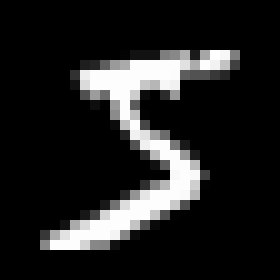

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [31]:
def to_pillow_image(x: FloatNDArray, scale: int = 10) -> PIL.Image.Image:
    '''Convert example of shape (28 * 28,) and values 0..1 to Pillow image.'''
    H = W = 28
    assert x.shape == (H * W,) and 0 <= x.min() <= x.max() <= 1
    x_int = (x * 255).astype(np.uint8).reshape(H, W)
    img = PIL.Image.fromarray(x_int, mode='L')
    return img.resize((H * scale, W * scale), PIL.Image.Resampling.NEAREST)


display(to_pillow_image(x_train[0]))
print(y_train[0])

## Exercise 1

In this exercise, your task is to fill in the gaps in this code by implementing the backpropagation algorithm.
Once done, you can run the network on the MNIST example and see how it performs.  
Feel free to play with the parameters. Your model should achieve 90%+ accuracy after a few epochs.  

Before you start you should note a few things:
+ `backprop` - is the function that you need to implement
+ `learning_step` - calls `backprop` to get the gradients for network parameters
+ The derivative of the loss is already computed by `cost_derivative`.
+ Your goal is to compute $\frac{d L\left(\text{model}(x), y\right)}{d p}$ for each parameter $p$ of the network


In [32]:
def sigmoid(z: FloatNDArray) -> FloatNDArray:
    return 1.0 / (1.0 + np.exp(-z))


def sigmoid_prime(z: FloatNDArray) -> FloatNDArray:
    '''Derivative of the sigmoid.'''
    return sigmoid(z) * (1 - sigmoid(z))

In [33]:
class Network:
    '''
    Multi-Layer Perceptron.

    A simple neural network with fully-connected layers and sigmoid activations.
    '''

    def __init__(self, sizes: Sequence[int] = (784, 30, 10)):
        '''
        Args:
        - sizes: sequence of layer widths [N^0, ... , N^last]
          These are lengths of activation vectors, where:
          - N^0 is input size: 784.
          - N^last is the number of classes into which we can classify each input: 10.
        '''
        self.sizes = list(sizes)

        # We initialize weights and biases with random normal distribution.

        # List of len(sizes) - 1 vectors of shape (N^1), (N^2), ..., (N^last).
        self.biases = [np.random.randn(n) for n in sizes[1:]]

        # List of len(sizes) - 1 matrices of shape (N^i, N^{i-1}).
        # Weights are indexed by target node first.
        self.weights = [
            np.random.randn(n_out, n_in) / np.sqrt(n_in)
            for n_in, n_out in zip(sizes[:-1], sizes[1:], strict=True)
        ]

    def feedforward(self, x: FloatNDArray) -> FloatNDArray:
        '''
        Run the network on a single case of shape (N^0,).

        Returns last layer activations, shape (N^last,), values 0..1.
        '''
        g = x
        for w, b in zip(self.weights, self.biases, strict=True):
            f = w @ g + b
            g = sigmoid(f)
        return g

    def learning_step(
        self, x_mini_batch: FloatNDArray, y_mini_batch: FloatNDArray, learning_rate: float
    ) -> None:
        '''
        Update network parameters with a single mini-batch step of backpropagation and gradient descent.

        Args:
        - x_mini_batch: shape (B, N^0) where B is the mini-batch size.
        - y_mini_batch: shape (B, N^last).
        - learning_rate.
        '''
        # Accumulate gradients by running backprop one dataitem at a time (without vectorization).
        grads_w = [np.zeros(w.shape) for w in self.weights]
        grads_b = [np.zeros(b.shape) for b in self.biases]
        for x, y in zip(x_mini_batch, y_mini_batch):
            item_grads_w, item_grads_b = self.backprop(x, y)
            for i in range(len(grads_w)):
                grads_w[i] = grads_w[i] + item_grads_w[i]
            for i in range(len(grads_b)):
                grads_b[i] = grads_b[i] + item_grads_b[i]

        # Gradient descent step.
        self.weights = [
            w - grad_w * (learning_rate / len(x_mini_batch))
            for w, grad_w in zip(self.weights, grads_w, strict=True)
        ]
        self.biases = [
            b - grad_b * (learning_rate / len(x_mini_batch))
            for b, grad_b in zip(self.biases, grads_b, strict=True)
        ]

    def backprop(
        self, x: FloatNDArray, y: FloatNDArray
    ) -> tuple[list[FloatNDArray], list[FloatNDArray]]:
        '''
        Backpropagation for a single input (not vectorized).

        Args:
        - x: input features, shape (N^0).
        - y: target label (one-hot encoded), shape (N^last).

        Returns (grads_w, grads_b), where:
        - grads_w is a list of gradients over weights (shape (N^i, N^{i-1})), for each layer.
        - grads_b is a list of gradients over biases (shape (N^i)), for each layer.
        '''

        # Go forward, remembering all activations.
        # Pre-activations function, layer by layer, shapes (N^1), ..., (N^last).
        fs: list[FloatNDArray] = []
        # Activations (including inputs to the first layer), shapes (N^0), (N^1), ..., (N^last).
        gs: list[FloatNDArray] = [x]

        # Forward pass
        current_x = x
        for w, b in zip(self.weights, self.biases):
            current_x = w @ current_x + b
            fs.append(current_x)
            current_x = sigmoid(current_x)
            gs.append(current_x)

        assert [f.shape for f in fs] == [(n,) for n in self.sizes[1:]], f'Shape mismatch: {[f.shape for f in fs]} vs {self.sizes[1:]}'
        assert [g.shape for g in gs] == [(n,) for n in self.sizes], f'Shape mismatch: {[g.shape for g in gs]} vs {self.sizes}'

        # print([f.shape for f in fs])
        # print([g.shape for g in gs])
        # print("shapes ok")

        # Now go backward from the final cost applying backpropagation.
        grad_g = self.cost_derivative(gs[-1], y)  # shape initially (N^last), then layer by layer.

        # TODO backward pass. May be useful:
        # - reversed(list(...)) can be used to iterate in reverse.
        # - list.reverse() reverses a list in-place.
        # - np.outer() computes an outer product (a_{i,j} = b_i c_j) very fast.

        grads_w = []
        grads_b = []

        # ---------------------- BACKWARD PASS BEGIN ---------------------

        for i in range(len(fs)-1, -1, -1):
            weights, bias, g, f = self.weights[i], self.biases[i], gs[i+1], fs[i]
            # print(weights.shape, bias.shape, g.shape, f.shape)

            grad_f = grad_g * g * (1-g)              # Element-wise Hadamard product
            grad_prev_g = weights.T @ grad_f
            grad_weights = np.outer(grad_f.T, gs[i]) # Product of two vectors is a matrix here
            grad_bias = grad_f
            # print(grad_f.shape, grad_prev_g.shape, grad_weights.shape, grad_bias.shape)

            grads_w.append(grad_weights)
            grads_b.append(grad_bias)

            grad_g = grad_prev_g

        grads_w.reverse()
        grads_b.reverse()

        # ---------------------- BACKWARD PASS END -----------------------

        # Now grads_w should have shapes (N^1, N^0), ..., (N^last, N^{last-1}).
        # Now grads_b should have shapes (N^1), ..., (N^last).
        for grad_b, b in zip(grads_b, self.biases, strict=True):
            assert grad_b.shape == b.shape, f'Shape mismatch: {grad_b.shape=} but {b.shape=}'
        for grad_w, w in zip(grads_w, self.weights, strict=True):
            assert grad_w.shape == w.shape, f'Shape mismatch: {grad_w.shape=} but {w.shape=}'

        return grads_w, grads_b

    def cost_derivative(self, g: FloatNDArray, y: FloatNDArray) -> FloatNDArray:
        '''
        Gradient of loss (MSE) over output activations, for a single sample.

        Args:
        - g: output activations, shape (N^last).
        - y: target values (one-hot encoded labels), shape (N^last).

        Returns gradients, shape (N^last).
        '''
        assert g.shape == y.shape, f'Shape mismatch: {g.shape=} but {y.shape=}'
        N_last, = g.shape
        return (2 / N_last) * (g- y.astype(np.float64))

    def evaluate(
        self, x_test_data: FloatNDArray, y_test_data: FloatNDArray
    ) -> np.float64:
        '''
        Compute accuracy: the ratio of correct answers for test_data.

        Args (here B is the number of test dataitems):
        - x_test_data: shape (B, N^0).
        - y_test_data: shape (B, N^last).
        '''
        test_results: list[bool] = []
        for x, y in zip(x_test_data, y_test_data):
            output_label: np.int64 = np.argmax(self.feedforward(x))
            target_label: np.int64 = np.argmax(y)
            test_results.append(output_label == target_label)

        return np.mean(test_results)

    def SGD(
        self,
        training_data: tuple[FloatNDArray, FloatNDArray],
        test_data: tuple[FloatNDArray, FloatNDArray] | None = None,
        epochs: int = 2,
        mini_batch_size: int = 100,
        learning_rate: float = 1.0,
    ) -> None:
        x_train, y_train = training_data
        for epoch in tqdm(range(epochs)):
            for i in range(x_train.shape[0] // mini_batch_size):
                i_begin = i * mini_batch_size
                i_end = (i + 1) * mini_batch_size
                self.learning_step(x_train[i_begin:i_end], y_train[i_begin:i_end], learning_rate)
            if test_data:
                x_test, y_test = test_data
                accuracy = self.evaluate(x_test, y_test)
                tqdm.write(f'Epoch: {epoch}, Accuracy: {accuracy * 100:.2f} %')
            else:
                tqdm.write(f'Epoch: {epoch}')

In [34]:
%%time
# Smaller test on part of the dataset.
# The unvectorized version should take about 2s per epoch
# and achieve accuracy ~75% or more (for most executions).
network = Network([784, 30, 10])
network.SGD(
    (x_train[:3000], y_train[:3000]),
    test_data=(x_test[:3000], y_test[:3000]),
    epochs=30,
    mini_batch_size=200,
    learning_rate=10.0
)

  3%|▎         | 1/30 [00:00<00:03,  7.69it/s]

Epoch: 0, Accuracy: 37.63 %


  7%|▋         | 2/30 [00:00<00:03,  7.59it/s]

Epoch: 1, Accuracy: 45.17 %


 10%|█         | 3/30 [00:00<00:03,  7.61it/s]

Epoch: 2, Accuracy: 50.93 %


 13%|█▎        | 4/30 [00:00<00:03,  7.55it/s]

Epoch: 3, Accuracy: 57.23 %


 17%|█▋        | 5/30 [00:00<00:03,  7.51it/s]

Epoch: 4, Accuracy: 60.03 %


 20%|██        | 6/30 [00:00<00:03,  7.43it/s]

Epoch: 5, Accuracy: 64.07 %


 23%|██▎       | 7/30 [00:00<00:03,  7.27it/s]

Epoch: 6, Accuracy: 67.83 %


 27%|██▋       | 8/30 [00:01<00:03,  7.03it/s]

Epoch: 7, Accuracy: 71.30 %


 30%|███       | 9/30 [00:01<00:02,  7.19it/s]

Epoch: 8, Accuracy: 74.47 %


 33%|███▎      | 10/30 [00:01<00:02,  7.32it/s]

Epoch: 9, Accuracy: 76.53 %


 37%|███▋      | 11/30 [00:01<00:02,  7.35it/s]

Epoch: 10, Accuracy: 78.73 %


 40%|████      | 12/30 [00:01<00:02,  7.43it/s]

Epoch: 11, Accuracy: 80.00 %


 43%|████▎     | 13/30 [00:01<00:02,  7.47it/s]

Epoch: 12, Accuracy: 80.93 %


 47%|████▋     | 14/30 [00:01<00:02,  7.50it/s]

Epoch: 13, Accuracy: 81.70 %


 50%|█████     | 15/30 [00:02<00:01,  7.55it/s]

Epoch: 14, Accuracy: 82.23 %


 53%|█████▎    | 16/30 [00:02<00:01,  7.54it/s]

Epoch: 15, Accuracy: 82.80 %


 57%|█████▋    | 17/30 [00:02<00:01,  7.55it/s]

Epoch: 16, Accuracy: 83.43 %


 60%|██████    | 18/30 [00:02<00:01,  7.56it/s]

Epoch: 17, Accuracy: 84.00 %


 63%|██████▎   | 19/30 [00:02<00:01,  7.55it/s]

Epoch: 18, Accuracy: 84.40 %


 67%|██████▋   | 20/30 [00:02<00:01,  7.57it/s]

Epoch: 19, Accuracy: 84.53 %


 70%|███████   | 21/30 [00:02<00:01,  7.57it/s]

Epoch: 20, Accuracy: 84.77 %


 73%|███████▎  | 22/30 [00:02<00:01,  7.57it/s]

Epoch: 21, Accuracy: 84.93 %


 77%|███████▋  | 23/30 [00:03<00:00,  7.57it/s]

Epoch: 22, Accuracy: 85.03 %


 80%|████████  | 24/30 [00:03<00:00,  7.59it/s]

Epoch: 23, Accuracy: 85.20 %


 83%|████████▎ | 25/30 [00:03<00:00,  7.61it/s]

Epoch: 24, Accuracy: 85.43 %


 87%|████████▋ | 26/30 [00:03<00:00,  7.64it/s]

Epoch: 25, Accuracy: 85.57 %


 90%|█████████ | 27/30 [00:03<00:00,  7.57it/s]

Epoch: 26, Accuracy: 85.83 %


 93%|█████████▎| 28/30 [00:03<00:00,  7.57it/s]

Epoch: 27, Accuracy: 85.90 %


 97%|█████████▋| 29/30 [00:03<00:00,  7.60it/s]

Epoch: 28, Accuracy: 85.97 %


100%|██████████| 30/30 [00:03<00:00,  7.51it/s]

Epoch: 29, Accuracy: 86.03 %
CPU times: total: 4.05 s
Wall time: 4 s


In [35]:
%%time
# Full test.
# The unvectorized version should take about 20s per epoch
# and achieve accuracy ~90% or more.
network = Network([784, 30, 10])
network.SGD(
    (x_train, y_train),
    test_data=(x_test, y_test),
    epochs=10,
    mini_batch_size=100,
    learning_rate=5.0
)

 10%|█         | 1/10 [00:02<00:19,  2.15s/it]

Epoch: 0, Accuracy: 88.50 %


 20%|██        | 2/10 [00:04<00:17,  2.15s/it]

Epoch: 1, Accuracy: 90.71 %


 30%|███       | 3/10 [00:06<00:15,  2.15s/it]

Epoch: 2, Accuracy: 91.65 %


 40%|████      | 4/10 [00:08<00:12,  2.15s/it]

Epoch: 3, Accuracy: 92.33 %


 50%|█████     | 5/10 [00:10<00:10,  2.15s/it]

Epoch: 4, Accuracy: 92.69 %


 60%|██████    | 6/10 [00:12<00:08,  2.16s/it]

Epoch: 5, Accuracy: 93.00 %


 70%|███████   | 7/10 [00:15<00:06,  2.16s/it]

Epoch: 6, Accuracy: 93.29 %


 80%|████████  | 8/10 [00:17<00:04,  2.16s/it]

Epoch: 7, Accuracy: 93.55 %


 90%|█████████ | 9/10 [00:19<00:02,  2.15s/it]

Epoch: 8, Accuracy: 93.70 %


100%|██████████| 10/10 [00:21<00:00,  2.15s/it]

Epoch: 9, Accuracy: 93.86 %
CPU times: total: 21.5 s
Wall time: 21.5 s


## Exercise 2

Implement a "fully vectorized" version, i.e. one using matrix operations instead of going over examples one by one within a minibatch.


In [36]:
class NetworkVectorized:
    '''Multi-Layer Perceptron with vectorized (batched) methods.'''

    def __init__(self, sizes: Sequence[int] = (784, 30, 10)):
        '''
        Args:
        - sizes: sequence of layer widths [N^0, ... , N^last]
          These are lengths of activation vectors, where:
          - N^0 is input size: 784.
          - N^last is the number of classes into which we can classify each input: 10.
        '''
        self.sizes = list(sizes)

        # We initialize weights and biases with random normal distribution.

        # List of len(sizes) - 1 vectors of shape (N^1), (N^2), ..., (N^last)
        self.biases = [np.random.randn(n) for n in sizes[1:]]

        # List of len(sizes) - 1 matrices of shape (N^i, N^{i-1}).
        # Weights are indexed by target node first.
        self.weights = [
            np.random.randn(n_out, n_in) / np.sqrt(n_in)
            for n_in, n_out in zip(sizes[:-1], sizes[1:], strict=True)
        ]

    def feedforward(self, x: FloatNDArray) -> FloatNDArray:
        '''
        Run the network on a batch of cases of shape (B, N^0), values 0..1.

        Returns last layer activations, shape (B, N^last), values 0..1.
        '''
        g = x
        for w, b in zip(self.weights, self.biases, strict=True):
            # (B, N_in) @ (N_in, N_out) -> (B, N_out)
            g = sigmoid(g @ w.T + b)
        return g

    def learning_step(self, x_mini_batch: FloatNDArray, y_mini_batch: FloatNDArray, learning_rate: float) -> None:
        '''
        Update network parameters with a single mini-batch step of backpropagation and gradient descent.

        Args:
        - x_mini_batch: shape (B, N^0) where B is mini_batch_size.
        - y_mini_batch: shape (B, N^last).
        - learning_rate.
        '''
        grads_w, grads_b = self.backprop_vectorized(x_mini_batch, y_mini_batch)

        # Gradient descent step.
        self.weights = [
            w - learning_rate * grad_w
            for w, grad_w in zip(self.weights, grads_w, strict=True)
        ]
        self.biases = [
            b - learning_rate * grad_b
            for b, grad_b in zip(self.biases, grads_b, strict=True)
        ]

    def backprop_vectorized(
        self, x: FloatNDArray, y: FloatNDArray
    ) -> tuple[list[FloatNDArray], list[FloatNDArray]]:
        '''Backpropagation for a mini-batch (vectorized).

        Args:
        - x: input, shape (B, N^0)
        - y: target label (one-hot encoded), shape (B, N^last)

        Returns (grads_w, grads_b), where:
        - grads_w: list of gradients over weights (shape (N^i, N^{i-1})), for each layer.
        - grads_b: list of gradients over biases (shape (N^i)), for each layer.
        '''
        B, N0 = x.shape
        assert N0 == self.sizes[0]

        # Go forward, remembering all activations.

        # Values after activation function (including inputs to the first layer),
        # shapes (B, N^0), (B, N^1), ..., (B, N^last).
        gs: list[FloatNDArray] = [x]

        g = x
        for w, b in zip(self.weights, self.biases, strict=True):
            # (B, N_in) @ (N_in, N_out) -> (B, N_out)
            g = sigmoid(g @ w.T + b)
            gs.append(g)

        assert [g.shape for g in gs] == [(B, n) for n in self.sizes], \
            f'Shape mismatch: {[g.shape for g in gs]} vs {[(B, n) for n in self.sizes]}'

        # Now go backward from the final cost applying backpropagation.
        grad_g = self.cost_derivative(gs[-1], y)  # shape initially (B, N^last), then layer by layer.

        grads_w = []
        grads_b = []

        # Loop backwards
        for i in reversed(range(len(self.weights))):
            g = gs[i + 1]          # (B, N^i)
            prev_g = gs[i]         # (B, N^{i-1})

            # grad_g has shape (B, N^i), initially (B, N^last)
            grad_f = grad_g * (g * (1 - g)) # (B, N^i)

            # average over batch
            grad_b = np.mean(grad_f, axis=0) # (N^i,)

            # weights gradient: (N^i, N^{i-1})
            grad_w = grad_f.T @ prev_g / B           # divide by B for mean

            grads_w.append(grad_w)
            grads_b.append(grad_b)

            # propagate gradient backward to previous layer
            # (B, N^i) @ (N^i, N^{i-1}) --> (B, N^{i-1})
            grad_g = grad_f @ self.weights[i]        # (B, N^{i-1})

        grads_w.reverse()
        grads_b.reverse()


        # Now grads_w should have shapes (N^1, N^0), ..., (N^last, N^{last-1}).
        # Now grads_b should have shapes (N^1,) ..., (N^last,).
        for grad_b, b in zip(grads_b, self.biases, strict=True):
            assert grad_b.shape == b.shape, f'Shape mismatch: {grad_b.shape=} but {b.shape=}'
        for grad_w, w in zip(grads_w, self.weights, strict=True):
            assert grad_w.shape == w.shape, f'Shape mismatch: {grad_w.shape=} but {w.shape=}'

        return grads_w, grads_b

    def cost_derivative(self, g: FloatNDArray, y: FloatNDArray) -> FloatNDArray:
        '''
        Gradient of loss (MSE) over output activations.

        Args:
        - g: output activations, shape (B, N^last).
        - y: target values (one-hot encoded labels), shape (B, N^last).

        Returns gradients, shape (B, N^last).
        '''
        assert g.shape == y.shape, f'Shape mismatch: {g.shape=} but {y.shape=}'
        B, N_last = g.shape
        return (2 / (B * N_last)) * (g - y.astype(np.float64))

    def evaluate(self, x_test_data: FloatNDArray, y_test_data: FloatNDArray) -> np.float64:
        '''
        Compute accuracy: the ratio of correct answers for test_data.

        Args:
        - x_test_data: shape (B, N^0).
        - y_test_data: shape (B, N^last).
        '''
        predictions = np.argmax(self.feedforward(x_test_data), axis=1)
        targets = np.argmax(y_test_data, axis=1)
        return np.mean(predictions == targets)

    def SGD(
        self,
        training_data: tuple[FloatNDArray, FloatNDArray],
        test_data: tuple[FloatNDArray, FloatNDArray] | None = None,
        epochs: int = 2,
        mini_batch_size: int = 100,
        learning_rate: float = 1.0
    ) -> None:
        x_train, y_train = training_data
        for epoch in tqdm(range(epochs)):
            for i in range(x_train.shape[0] // mini_batch_size):
                i_begin = i * mini_batch_size
                i_end = (i + 1) * mini_batch_size
                self.learning_step(x_train[i_begin:i_end], y_train[i_begin:i_end], learning_rate)
            if test_data:
                x_test, y_test = test_data
                accuracy = self.evaluate(x_test, y_test)
                print(f'Epoch: {epoch}, Accuracy: {accuracy * 100:.2f} %')
            else:
                print(f'Epoch: {epoch}')

In [37]:
%%time
# The vectorized version takes about ~1s per epoch.
network = NetworkVectorized([784, 30, 10])
network.SGD(
    (x_train, y_train),
    test_data=(x_test, y_test),
    epochs=50,
    mini_batch_size=100,
    learning_rate=10.0
)

  2%|▏         | 1/50 [00:00<00:09,  5.35it/s]

Epoch: 0, Accuracy: 37.70 %
Epoch: 1, Accuracy: 40.53 %


  8%|▊         | 4/50 [00:00<00:08,  5.34it/s]

Epoch: 2, Accuracy: 42.00 %
Epoch: 3, Accuracy: 43.27 %


 12%|█▏        | 6/50 [00:01<00:08,  5.33it/s]

Epoch: 4, Accuracy: 44.70 %
Epoch: 5, Accuracy: 46.75 %


 16%|█▌        | 8/50 [00:01<00:07,  5.31it/s]

Epoch: 6, Accuracy: 49.25 %
Epoch: 7, Accuracy: 52.03 %


 18%|█▊        | 9/50 [00:01<00:07,  5.28it/s]

Epoch: 8, Accuracy: 55.65 %
Epoch: 9, Accuracy: 59.10 %


 22%|██▏       | 11/50 [00:02<00:07,  5.32it/s]

Epoch: 10, Accuracy: 62.71 %
Epoch: 11, Accuracy: 65.44 %


 26%|██▌       | 13/50 [00:02<00:06,  5.32it/s]

Epoch: 12, Accuracy: 67.88 %
Epoch: 13, Accuracy: 70.05 %


 30%|███       | 15/50 [00:02<00:06,  5.33it/s]

Epoch: 14, Accuracy: 71.79 %
Epoch: 15, Accuracy: 73.17 %


 34%|███▍      | 17/50 [00:03<00:06,  5.31it/s]

Epoch: 16, Accuracy: 74.36 %
Epoch: 17, Accuracy: 75.50 %


 38%|███▊      | 19/50 [00:03<00:05,  5.32it/s]

Epoch: 18, Accuracy: 76.45 %
Epoch: 19, Accuracy: 77.26 %


 42%|████▏     | 21/50 [00:03<00:05,  5.30it/s]

Epoch: 20, Accuracy: 78.09 %
Epoch: 21, Accuracy: 78.85 %


 46%|████▌     | 23/50 [00:04<00:05,  5.28it/s]

Epoch: 22, Accuracy: 79.81 %
Epoch: 23, Accuracy: 80.78 %


 52%|█████▏    | 26/50 [00:04<00:04,  5.35it/s]

Epoch: 24, Accuracy: 81.61 %
Epoch: 25, Accuracy: 82.31 %


 54%|█████▍    | 27/50 [00:05<00:04,  5.30it/s]

Epoch: 26, Accuracy: 83.04 %
Epoch: 27, Accuracy: 83.80 %


 58%|█████▊    | 29/50 [00:05<00:03,  5.31it/s]

Epoch: 28, Accuracy: 84.49 %
Epoch: 29, Accuracy: 84.98 %


 62%|██████▏   | 31/50 [00:05<00:03,  5.32it/s]

Epoch: 30, Accuracy: 85.44 %
Epoch: 31, Accuracy: 85.98 %


 66%|██████▌   | 33/50 [00:06<00:03,  5.34it/s]

Epoch: 32, Accuracy: 86.31 %
Epoch: 33, Accuracy: 86.65 %


 70%|███████   | 35/50 [00:06<00:02,  5.36it/s]

Epoch: 34, Accuracy: 86.87 %
Epoch: 35, Accuracy: 87.22 %


 74%|███████▍  | 37/50 [00:06<00:02,  5.37it/s]

Epoch: 36, Accuracy: 87.48 %
Epoch: 37, Accuracy: 87.63 %


 80%|████████  | 40/50 [00:07<00:01,  5.38it/s]

Epoch: 38, Accuracy: 87.86 %
Epoch: 39, Accuracy: 88.10 %


 84%|████████▍ | 42/50 [00:07<00:01,  5.38it/s]

Epoch: 40, Accuracy: 88.22 %
Epoch: 41, Accuracy: 88.40 %


 88%|████████▊ | 44/50 [00:08<00:01,  5.40it/s]

Epoch: 42, Accuracy: 88.48 %
Epoch: 43, Accuracy: 88.57 %


 92%|█████████▏| 46/50 [00:08<00:00,  5.41it/s]

Epoch: 44, Accuracy: 88.74 %
Epoch: 45, Accuracy: 88.88 %


 96%|█████████▌| 48/50 [00:09<00:00,  5.22it/s]

Epoch: 46, Accuracy: 88.96 %
Epoch: 47, Accuracy: 89.06 %


 98%|█████████▊| 49/50 [00:09<00:00,  5.28it/s]

Epoch: 48, Accuracy: 89.10 %
Epoch: 49, Accuracy: 89.13 %


100%|██████████| 50/50 [00:09<00:00,  5.32it/s]

CPU times: total: 30 s
Wall time: 9.4 s


# Exercise 3 (optional)

The standard backpropagation method requires memorization of all outputs of all layers computed during the forward pass, for use in the backward pass, which can take much of precious GPU memory.
Instead of doing that, one can checkpoint (memorize) only activations of a select few layers and then recompute the rest as they are needed (redoing the forward pass between checkpoints).  
Your task is to complete the code below to implement backpropagation with checkpoints.

In [38]:
class NetworkWithCheckpoints(NetworkVectorized):
    '''Multi-Layer Perceptron with gradient checkpointing.'''

    def __init__(self, sizes: Sequence[int] = (784, 30, 10), checkpoints: Sequence[int] = (1,)):
        '''
        Args:
        - sizes: sequence of layer widths [N^0, ... , N^last]
          These are lengths of activation vectors, where:
          - N^0 is input size: 784.
          - N^last is the number of classes into which we can classify each input: 10.
        - checkpoints: Indices of layers whose activations we want to checkpoint
          (between 1 and last inclusive (last=len(sizes) - 1).
        '''
        super().__init__(sizes)
        last_layer_id = len(sizes) - 1
        # Always store the input and last activations.
        self.checkpoints = sorted(set(checkpoints) | {0, last_layer_id})

    def backprop_generator(
        self, x: FloatNDArray, y: FloatNDArray
    ) -> Iterator[tuple[FloatNDArray, FloatNDArray]]:
        '''
        Backpropagation for a mini-batch (vectorized).

        Args:
        - x: input, shape (B, N^0)
        - y: target label (one-hot encoded), shape (B, N^last)

        Yields (grad_w, grad_b) for each layer from i=last down to i=1, where:
        - grads_w: shape (N^i, N^{i-1})).
        - grads_b: shape (N^i)).
        '''
        B, N0 = x.shape
        assert N0 == self.sizes[0]

        # Go forward, remembering only some activations and no pre-activations.

        # Values after activation function (including inputs to the first layer),
        # shapes (B, N^0), (B, N^1), ..., (B, N^last);
        # layers that are not checkpointed get None instead.
        gs: list[FloatNDArray | None] = [x]

        # TODO forward pass.
        g = x
        j = -1
        # print(self.checkpoints)
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
          g = sigmoid(g @ w.T + b)
          # print(i, g.shape)
          while j + 1 < len(self.checkpoints) and self.checkpoints[j + 1] < i:
            j += 1

          gs.append(g if j < len(self.checkpoints) and self.checkpoints[j] + 1== i else None)

        # print([curr_g.shape for curr_g in gs if curr_g is not None])

        # Now go backward from the final cost applying backpropagation.
        grad_g = self.cost_derivative(g, y)  # shape initially (B, N^last), then layer by layer.

        # TODO backward pass.
        for i in range(len(self.checkpoints)-1, 0, -1):
            start_i = self.checkpoints[i-1]
            end_i = self.checkpoints[i]

            # print(start_i, end_i)

            # for each interval between consecutive checkpoints:
            # Forward pass to restore intermediate activations.
            # for all layers in interval:
            # ...
            intermediate_gs = [gs[start_i]]
            g = gs[start_i]
            for j in range(start_i, end_i):
                g = sigmoid(g @ self.weights[j].T + self.biases[j])
                intermediate_gs.append(g)

            # Now g and grad_g have shape (B, N^{end_i}).
            assert g.shape == grad_g.shape == (B, self.sizes[end_i]) # type: ignore

            # Backward pass between the checkpoints.
            # for all layers in the interval, backwards:
            #   # Compute grad_w, grad_b.
            #   # Yield them as we go, instead of returning a list.
            #   # https://docs.python.org/3/tutorial/classes.html#generators
            #   yield (grad_w, grad_b)
            for j in range(end_i-1, start_i-1, -1):
                # grad_g has shape (B, N^{j})
                # grad_f has the same shape
                grad_f = grad_g * intermediate_gs[j - start_i + 1] * (1 - intermediate_gs[j - start_i + 1]) # type: ignore
                # print(j, grad_g.shape, grad_f.shape)
                # shape (B,)
                grad_b = np.mean(grad_f, axis=0)

                grad_w = grad_f.T @ intermediate_gs[j - start_i] / B
                grad_g = grad_f @ self.weights[j]

                yield (grad_w, grad_b)

            # print(grad_g.shape, self.sizes[start_i])
            # Now grad_g has shape (B, N^{start_i}).
            assert grad_g.shape == (B, self.sizes[start_i])

    @override
    def learning_step(self, x_mini_batch: FloatNDArray, y_mini_batch: FloatNDArray, learning_rate: float) -> None:
        '''
        Update network parameters with a single mini-batch step of backpropagation and gradient descent.

        Args:
        - x_mini_batch: shape (B, N^0) where B is mini_batch_size.
        - y_mini_batch: shape (B, N^last).
        - learning_rate.
        '''
        indices = range(len(self.sizes) - 1, 0, -1)  # From `last` down to 1 inclusive.
        for i, (grad_w, grad_b) in zip(indices, self.backprop_generator(x_mini_batch, y_mini_batch), strict=True):
            self.weights[i - 1] = self.weights[i - 1] - learning_rate * grad_w
            self.biases[i - 1] = self.biases[i - 1] - learning_rate * grad_b
np.random.seed(42)
network = NetworkWithCheckpoints([784, 20, 15, 13, 10], checkpoints=[2])
network.SGD(
    (x_train, y_train),
    test_data=(x_test, y_test),
    epochs=1,
    mini_batch_size=100,
    learning_rate=50.
)

100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

Epoch: 0, Accuracy: 10.27 %


In [39]:

%%memit -r 1 -o
# Compare on the same seed, results should be exactly the same.

np.random.seed(42)
network = NetworkWithCheckpoints([784, 20, 15, 13, 10], checkpoints=[2])
network.SGD(
    (x_train, y_train),
    test_data=(x_test, y_test),
    epochs=1,
    mini_batch_size=100,
    learning_rate=50.
)

np.random.seed(42)
network = NetworkVectorized([784, 20, 15, 13, 10])
network.SGD(
    (x_train, y_train),
    test_data=(x_test, y_test),
    epochs=1,
    mini_batch_size=100,
    learning_rate=50.
)

100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 0, Accuracy: 10.27 %


100%|██████████| 1/1 [00:00<00:00,  5.76it/s]

Epoch: 0, Accuracy: 10.27 %


peak memory: 772.95 MiB, increment: 0.29 MiB


<MemitResult : peak memory: 772.95 MiB, increment: 0.29 MiB>

 Memory usage can be checked by installing `memory_profiler` and using `%%memit` (instead of `%%time`),
 but it will be very hard to see a difference from checkpointing for an MLP.

# JAX Playground (Optional)
JAX is a framework that allows the creation of neural networks with numpy-like syntax.  
In this course, we will use Pytorch instead of JAX, but for this lab scenario, JAX can help us test our gradient computation implementation.  
Let's give it a try  

In [46]:
import jax
import jax.numpy as jnp
from textwrap import dedent


def jax_sigmoid(z: jax.Array) -> jax.Array:
    return 1.0 / (1.0 + jnp.exp(-z))


def jax_sigmoid_prime(z: jax.Array) -> jax.Array:
    s = jax_sigmoid(z)
    return s * (1 - s)


# Define a jax function.
# We emphasize that this is a function, not a jax procedure,
# and in fact there are more requirements for writing good jax code,
# but this is just an example.
# (see https://jax.readthedocs.io/en/latest/tutorials.html)
def jax_forward(x: jax.Array, w: jax.Array, b: jax.Array) -> tuple[jax.Array, jax.Array]:
    f = jnp.dot(x, w.T) + b  # Linear layer
    g = jax_sigmoid(f)
    loss = g.sum()  # Just a dummy loss for simplicity.
    return loss, g


# This will calculate gradient for first, second, and third argument.
# has_aux tells that in addition to loss our function returns something more.
auto_backward = jax.value_and_grad(fun=jax_forward, argnums=[0, 1, 2], has_aux=True)

def manual_backward(x: jax.Array, w: jax.Array, b: jax.Array) -> tuple[jax.Array, jax.Array, jax.Array]:
    f = jnp.dot(x, w.T) + b  # Linear layer
    grad_g = jnp.ones_like(f)  # Grad of the dummy loss over activations g.
    grad_f = grad_g * jax_sigmoid_prime(f) 
    grad_b = jnp.sum(grad_f, axis=0)
    grad_w = jnp.dot(grad_f.T, x)
    grad_x = jnp.dot(grad_f, w)
    return grad_x, grad_w, grad_b

def example():
    B, N0, N1 = 3, 5, 7

    key = jax.random.key(42)
    key, subkey = jax.random.split(key)
    w = jax.random.normal(subkey, (N1, N0))
    key, subkey = jax.random.split(key)
    b = jax.random.normal(subkey, (N1,))
    x = jnp.arange(N0, dtype=w.dtype).reshape(1, N0) * jnp.ones((B, N0))

    (loss, res), (jax_dx, jax_dw, jax_db) = auto_backward(x, w, b)
    dx, dw, db = manual_backward(x, w, b)

    print(dedent(f'''
        diff dx = {jnp.mean(jnp.abs(jax_dx - dx))}
        diff dw = {jnp.mean(jnp.abs(jax_dw - dw))}
        diff db = {jnp.mean(jnp.abs(jax_db - db))}
        dtype={dx.dtype} (eps={np.finfo(dx.dtype).eps})
    ''').strip())


example()

diff dx = 4.060566638486307e-08
diff dw = 9.451593996345764e-08
diff db = 4.789659158177528e-08
dtype=float32 (eps=1.1920928955078125e-07)
